In [70]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [71]:
import random,math
import numpy as np
from collections import defaultdict

class QLearningAgent():
  """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
  """
  def __init__(self,alpha,epsilon,discount,getLegalActions):
    "We initialize agent and Q-values here."
    self.getLegalActions = getLegalActions
    self._qValues = defaultdict(lambda:defaultdict(lambda:0))
    self.alpha = alpha
    self.epsilon = epsilon
    self.discount = discount

  def getQValue(self, state, action):
    #print(state)
    #print(action)
    return self._qValues[state][action]

  def setQValue(self,state,action,value):
    """
      Sets the Qvalue for [state,action] to the given value
    """
    self._qValues[state][action] = value

#---------------------#start of your code#---------------------#

  def getValue(self, state): # max Q(state, action)
    possibleActions = self.getLegalActions(state)
    if len(possibleActions) == 0:
      return 0.0
    return max([self.getQValue(state, act) for act in possibleActions])

  def getPolicy(self, state): # best action in Q(state, action)
    possibleActions = self.getLegalActions(state)
    if len(possibleActions) == 0:
      return None
    actionsVal = [(act, self.getQValue(state, act)) for act in possibleActions]
    return max(actionsVal, key=lambda x: x[1])[0]

  def getAction(self, state): # compute action to take in state
    possibleActions = self.getLegalActions(state)
    if len(possibleActions) == 0:
      return None
    action = None
    if random.random() < self.epsilon:
      action = random.choice(possibleActions)
    else:
      action = self.getPolicy(state)

    return action

  def update(self, state, action, nextState, reward): # update Q[state, action]
    gamma = self.discount
    learning_rate = self.alpha

    self.setQValue(state, action, self.getQValue(state, action) + learning_rate * (reward + gamma * self.getValue(nextState) - self.getQValue(state, action)))

In [72]:
import gymnasium as gym

env = gym.make("Taxi-v3")
n_states = env.observation_space.n # type: ignore
n_actions = env.action_space.n     # type: ignore



In [73]:
def play_and_train(env, agent, t_max=10**4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s, _ = env.reset()


    for t in range(t_max):
        a = agent.getAction(s)

        next_s, r, term, trunc, _ = env.step(a)

        #<train(update) agent for state s>
        agent.update(s, a, next_s, r)

        s = next_s
        total_reward += r
        if term or trunc:
            break
    return total_reward

Достигните положительной награды, постройте график

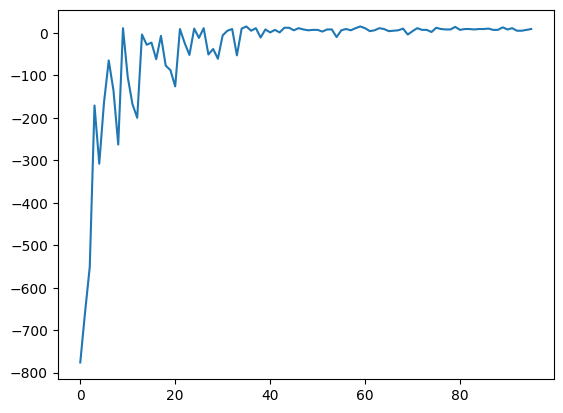

Last reward:  6.0


In [74]:
from IPython.display import clear_output
rewards = []
agent = QLearningAgent(alpha=0.15, epsilon=1.0, discount=0.98, getLegalActions = lambda s: range(n_actions))

cur_r = 0

for i in range(2000):
    cur_r = play_and_train(env, agent, t_max=10000)
    agent.epsilon *= 0.98
    if i % 20 == 0:
        rewards.append(cur_r)
    if i % 100 == 0:
        clear_output(True)
        plt.plot(rewards)
        plt.show()

print("Last reward: ", cur_r)


## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [75]:
env = gym.make("CartPole-v1")
n_actions = env.action_space.n # type: ignore
print("first state:%s"%(env.reset()[0]))

cart_pos_range = (-2.4, 2.4)
cart_vel_range = (-3.0, 3.0)
pole_ang_range = (-0.2095, 0.2095)
pole_vel_range = (-3.5, 3.5)

cart_pos_bin = np.linspace(cart_pos_range[0], cart_pos_range[1], 5)
cart_vel_bin = np.linspace(cart_vel_range[0], cart_vel_range[1], 5)
pole_ang_bin = np.linspace(pole_ang_range[0], pole_ang_range[1], 11)
pole_vel_bin = np.linspace(pole_vel_range[0], pole_vel_range[1], 11)

first state:[-0.03158781  0.04631542  0.04025005  0.03717876]


### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

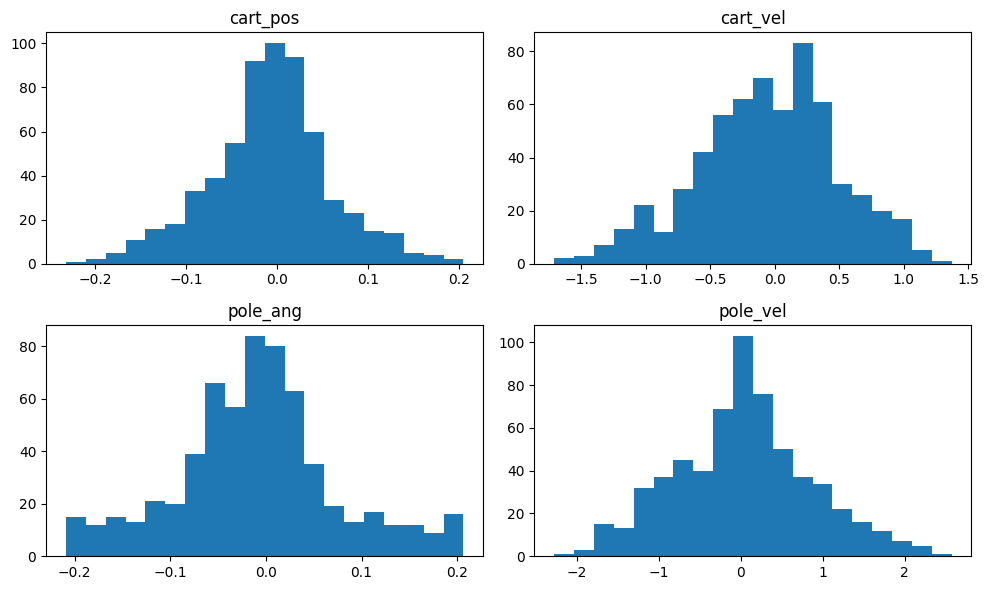

In [76]:
cnt_games = 30
t = 1000

states = []

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i in range(cnt_games):
    s, _ = env.reset()
    for j in range(t):
        states.append(s)
        a = env.action_space.sample() # type: ignore
        s, r, term, trunc, _ = env.step(a)
        if term or trunc:
            break

name = ["cart_pos", "cart_vel", "pole_ang", "pole_vel"]

for i in range(4):
    ax = axes[i // 2][i % 2]
    ax.hist([s[i] for s in states], bins=20)
    ax.set_title(name[i])
plt.tight_layout()
plt.show()

## Binarize environment

In [77]:
from gym.core import ObservationWrapper

class Binarizer(ObservationWrapper):

    def to_bin(self, value, bins):
        return np.digitize(value, bins)

    def observation(self, state):
        state =  (
            self.to_bin(state[0], cart_pos_bin),
            self.to_bin(state[1], cart_vel_bin),
            self.to_bin(state[2], pole_ang_bin),
            self.to_bin(state[3], pole_vel_bin)
        )
        return state

In [78]:
env = Binarizer(gym.make("CartPole-v1"))

## Learn

In [97]:
agent = QLearningAgent(alpha=0.5,epsilon=0.1,discount=0.99,getLegalActions = lambda s: range(n_actions))

0.08475428503023451
266.49


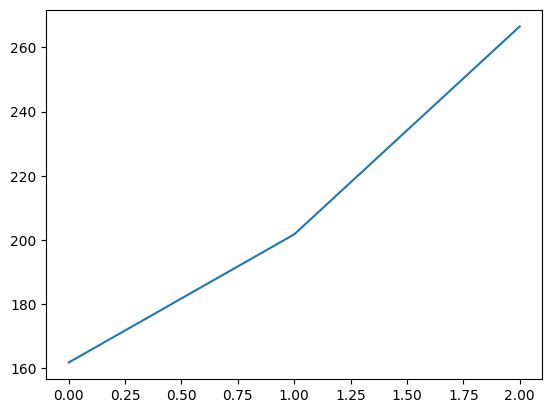

Win!


In [101]:
rewards = []
rewBuf = []
ma = -1000000000000
for i in range(50):
    for j in range(200):
        rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.995
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    plt.show()
    if(rewBuf[-1] > 230):
        print("Win!")
        break


## 4. Experience replay (5 pts)

In [ ]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._replaceId = 0


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            self._storage[self._replaceId] = data
            self._replaceId = (self._replaceId + 1) % self._maxsize
        else:
            self._storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        if len(self._storage) == 1 and batch_size == 1:
            return self._storage[0]

        idxes = [random.randrange(len(self._storage)) for _ in range(batch_size)]
        batch = [self._storage[i] for i in idxes]

        states, actions, rewards, next_states, is_done = zip(*batch)

        states = np.array(states, dtype=object)
        actions = np.array(actions, dtype=object)
        rewards = np.array(rewards, dtype=object)
        next_states = np.array(next_states, dtype=object)
        is_done = np.array(is_done, dtype=object)

        return states, actions, rewards, next_states, is_done


Some tests to make sure your buffer works right

In [105]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [109]:
import gymnasium as gym
env = Binarizer(gym.make('CartPole-v1'))
n_actions = env.action_space.n # type: ignore

In [111]:
agent = QLearningAgent(alpha=0.5,epsilon=0.1,discount=0.99,getLegalActions = lambda s: range(n_actions))
replay = ReplayBuffer(10000)

In [126]:
def play_and_train(env, agent, t_max=10**4, batch_size=10):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        action = agent.getAction(s)
        next_s, r, terminated, truncated, _ = env.step(action)
        replay.add(s, action, r, next_s, terminated or truncated)
        agent.update(s, action, next_s, r)

        s = next_s
        total_reward +=r
        if terminated or truncated:
            break

    st, ac, re, nst, don = replay.sample(batch_size)
    for i in range(batch_size):
        agent.update(st[i], ac[i], nst[i], re[i])
    return total_reward




Train with experience replay

0.028758360936686458
404.15


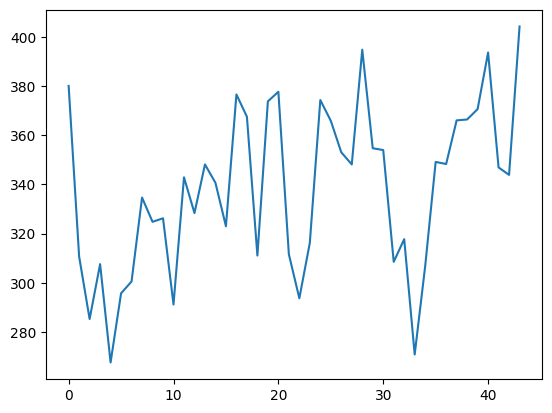

Win!


In [124]:
rewards = []
rewBuf = []
ma = -1000000000000
for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent, batch_size=1000))
    agent.epsilon *= 0.99
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    plt.show()
    if(rewBuf[-1] > 400):
        print("Win!")
        break
